# Installation
CNGI documentation is located here:
[https://cngi-prototype.readthedocs.io/en/latest/index.html](https://cngi-prototype.readthedocs.io/en/latest/index.html)

Google Colab requires specific older versions of some packages such as Pandas and Dask, so we will install CNGI without its normal dependencies and then manually install each dependency afterwards.

Normally, you would want to leave out the --no-dependencies option

For this demonstration we will use the data from the ALMA First Look at Imaging CASAguide

In [1]:
import os
import logging
logging.getLogger('distributed.utils_perf').setLevel(logging.ERROR) # dask is noisy

print("installing cngi (takes a few minutes)...")
os.system("apt-get install libgfortran3")
os.system("pip install --extra-index-url https://casa-pip.nrao.edu/repository/pypi-casa-release/simple casatools==6.0.0.27")
os.system("pip install --extra-index-url https://casa-pip.nrao.edu/repository/pypi-casa-release/simple casatasks==6.0.0.27")
os.system("pip install cngi-prototype==0.0.17 --no-dependencies")
os.system("pip install --upgrade dask")
os.system("pip install --upgrade xarray")
os.system("pip install --upgrade zarr")

print("downloading MeasurementSet from CASAguide First Look at Imaging...")
os.system("wget https://bulk.cv.nrao.edu/almadata/public/working/sis14_twhya_calibrated_flagged.ms.tar")
os.system("tar -xvf sis14_twhya_calibrated_flagged.ms.tar")

print('complete')

installing cngi (takes a few minutes)...
downloading MeasurementSet from CASAguide First Look at Imaging...
complete


# Initialize the Processing Environment
This is a bit limited with Colab and produces some warnings, but will still work.  It is not actually needed as Dask will default to its built in scheduler when none is provided, but is shown here as an example only.

InitializeFramework instantiates a client object (does not need to be returned and saved by caller). Once this object exists, all Dask objects automatically know to use it for parallel execution.

Omitting this step will cause the subsequent Dask dataframe operations to use the default built-in scheduler for parallel execution (which can actually be faster on local machines anyway)

In [2]:
from cngi.direct import InitializeFramework
client = InitializeFramework(2,'6GB',False)
client

/usr/local/lib/python3.6/dist-packages/distributed/bokeh/core.py:57: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 99] Cannot assign requested address
  warnings.warn('\n' + msg)
/usr/local/lib/python3.6/dist-packages/distributed/deploy/local.py:197: UserWarning: 
Could not launch service 'bokeh' on port 8787. Got the following message:

[Errno 99] Cannot assign requested address
  self.scheduler.start(scheduler_address)


Client Scheduler: inproc://172.28.0.2/124/1,Cluster Workers: 2 Cores: 2 Memory: 12.00 GB


# Create a CASA Image
First we need to create a CASA image by calling CASA6 tclean on the CASAguide MS

Pro tip: you can see the files being created by expanding the left navigation bar in colab (little arrow on top left) and going to "Files"

In [3]:
from casatasks import tclean
tclean(vis='sis14_twhya_calibrated_flagged.ms', imagename='sis14_twhya_calibrated_flagged', field='5', spw='', 
       specmode='mfs', deconvolver='hogbom', nterms=1, imsize=[250,250], gridder='standard', cell=['0.1arcsec'],
       weighting='natural', threshold='0mJy', niter=5000, interactive=False, savemodel='modelcolumn')
print('complete')

complete


# Convert the Image products to xarray/zarr format
tclean produces an image along with a number of supporting products (residual, pb, psf, etc) in their own separate directories.  

CNGI uses an [xarray](http://xarray.pydata.org/en/stable/data-structures.html#dataset) data model and the zarr storage format which is capable of storing all image products (of the same shape) together.

In [4]:
from cngi.conversion import image_to_zarr

image_to_zarr('sis14_twhya_calibrated_flagged.image')

converting Image...
compatible components:  ['image', 'mask', 'model', 'pb', 'psf', 'residual']
separate components:  ['sumwt']
processing channel 1 of 1
processed image size [250 250   1   1] in 0.40245366 seconds
processing sumwt channel 1 of 1
complete


# Open a zarr format Image

Open the zarr format image and print its contents.  Note that the zarr file has all the image products in it (rather than separate directories) except for sumwt, which remains its own file.  This is because sumwt has a different shape.


In [0]:
from cngi.dio import read_image

# returns an xarray dataset representation of the specified zarr directory
image_xds = read_image('sis14_twhya_calibrated_flagged.zarr')
sumwt_xds = read_image('sis14_twhya_calibrated_flagged.sumwt.zarr')

Within the xarray dataset image, we can see a very clear definition of the image properties.  The **Dimensions** section holds the size of the image, while the **Coordinates** section defines the values of each dimension.  The actual image (and supporting products) are stored in the **Data variables** section.  Lastly, the **Attributes** section holds the remaining metadata.

Note that the image, mask, model, pb, psf, and residual all share the same dimensions of 250x250x1x1

In [6]:
print(image_xds)

<xarray.Dataset>
Dimensions:          (d0: 250, d1: 250, frequency: 1, stokes: 1)
Coordinates:
    declination      (d0, d1) float64 dask.array<chunksize=(125, 250), meta=np.ndarray>
  * frequency        (frequency) float64 3.726e+11
    right_ascension  (d0, d1) float64 dask.array<chunksize=(125, 250), meta=np.ndarray>
  * stokes           (stokes) float64 1.0
Dimensions without coordinates: d0, d1
Data variables:
    image            (d0, d1, stokes, frequency) float64 dask.array<chunksize=(125, 250, 1, 1), meta=np.ndarray>
    mask             (d0, d1, stokes, frequency) float64 dask.array<chunksize=(125, 250, 1, 1), meta=np.ndarray>
    model            (d0, d1, stokes, frequency) float64 dask.array<chunksize=(125, 250, 1, 1), meta=np.ndarray>
    pb               (d0, d1, stokes, frequency) float64 dask.array<chunksize=(125, 250, 1, 1), meta=np.ndarray>
    psf              (d0, d1, stokes, frequency) float64 dask.array<chunksize=(125, 250, 1, 1), meta=np.ndarray>
    residual    

The same structure is followed for sumwt, but with different dimensions (1x1x1x1)

In [7]:
print(sumwt_xds)

<xarray.Dataset>
Dimensions:          (d0: 1, d1: 1, frequency: 1, stokes: 1)
Coordinates:
    declination      (d0, d1) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
  * frequency        (frequency) float64 3.726e+11
    right_ascension  (d0, d1) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
  * stokes           (stokes) float64 1.0
Dimensions without coordinates: d0, d1
Data variables:
    sumwt            (d0, d1, stokes, frequency) float64 dask.array<chunksize=(1, 1, 1, 1), meta=np.ndarray>
Attributes:
    axisunits:            ['rad', 'rad', '', 'Hz']
    date_observation:     2012/11/19/07
    defaultmask:          
    direction_reference:  j2000
    hasmask:              False
    image_name:           sis14_twhya_calibrated_flagged.sumwt
    image_quantity:       intensity
    image_type:           pagedimage
    imagetype:            Intensity
    masks:                []
    object_name:          tw hya
    observer:             cqi
    pixel_mask(s):        

# Preview Image
Before doing any sort of analysis, it's nice to spot check the image contents.  This is also handy during analysis to make sure things are progressing as intended.

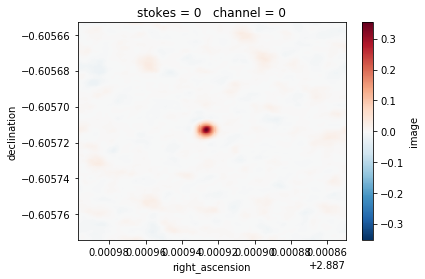

In [8]:
from cngi.image import preview
preview(image_xds, 'image')

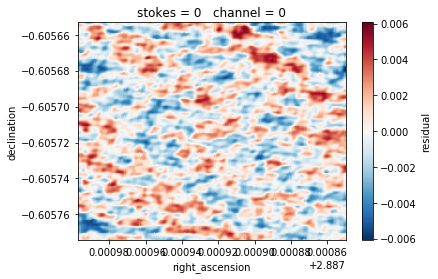

In [9]:
preview(image_xds, 'residual')

# Image Manipulation and Analysis
tbd